In [59]:
# Adding the path of the agent's class as a system path
import sys
sys.path.append('../src')
import EVs_naive_policy as EVs_naive_policy
import EV_milp_policy as EV_milp_policy
import EV_TS_Agent as EV_TS_Agent


# Importing required libraries
import subprocess
import argparse
import math
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from itertools import chain
from statistics import mean
import random
from functools import reduce
from scipy import signal, spatial
from scipy.stats import norm
import  seaborn as sns

# Input EVs Data

In [4]:
p_max = 7 # Rated charging power of each EV (in kW)
e_bat = 54 # Battery capacity (in kWh)
congestion_limit = 56 # Congestion limit (in kW)
bat_eff = 0.95 # Battery's charging efficiency
daily_decision_instants  = 1440

In [5]:
# Reading EVs data (arrival times, departure times, initial SoC, final SoC, chrage required)
evs_df = pd.read_csv(r'../data/EV/evs_data.csv' , index_col=False)
evs_df.head()

t_arrive  t_depart    soc_i  soc_f  chrg_req
0       540      1059  0.30333    0.8       234
1       600      1065  0.30333    0.8       234
2       383       745  0.71024    0.8        43
3       684      1032  0.30333    0.8       234
4       826      1349  0.30333    0.8       234

# Input Solar Data

In [113]:
new_index = {} # Dictitonary to index dataframe
pv_data = {} # Dictionary to hold PV data
year_last = int('2020')+1
y1 = '01/01/'+'2020'+' 00:00' # Starting date and time of the dataset
y2 = '31/12/'+'2020'+' 23:55' # Enging date and time of the dataset
new_index.update({'2020': pd.date_range(y1,y2,freq='5T')}) # Create an index for the dataset

#Location of the PV data file
data_file = pd.read_csv(r'../data/Solar/2020.csv',low_memory=False)
data_file.columns = data_file.iloc[1] # Change the columns name

# Extract important data for application, ie GHI :Gloal horizontal Iradiance
data_bis = pd.DataFrame(data=data_file.iloc[2:,[7,10]])
data_bis.index=new_index['2020']
for elmm in data_bis.columns:
    data_bis[elmm] = np.array(data_bis[elmm], dtype=float)

# Dictionary of PV data
pv_data.update({'2020':data_bis })

In [114]:
# Numpy array to store PV data used in Simulation studies
solar_data = np.zeros([60,daily_decision_instants])
day = 0 # Starting day index

# Storing each day's solar data in the solar_data array
for i in range(92,92+60):
    day_data_df = signal.resample(pv_data['2020']['GHI'][i*288:(i+1)*288].values,daily_decision_instants)
    solar_data[day] = day_data_df * 0.06
    day = day+1

# Setting all negative values as zero
solar_data[solar_data<0] = 0

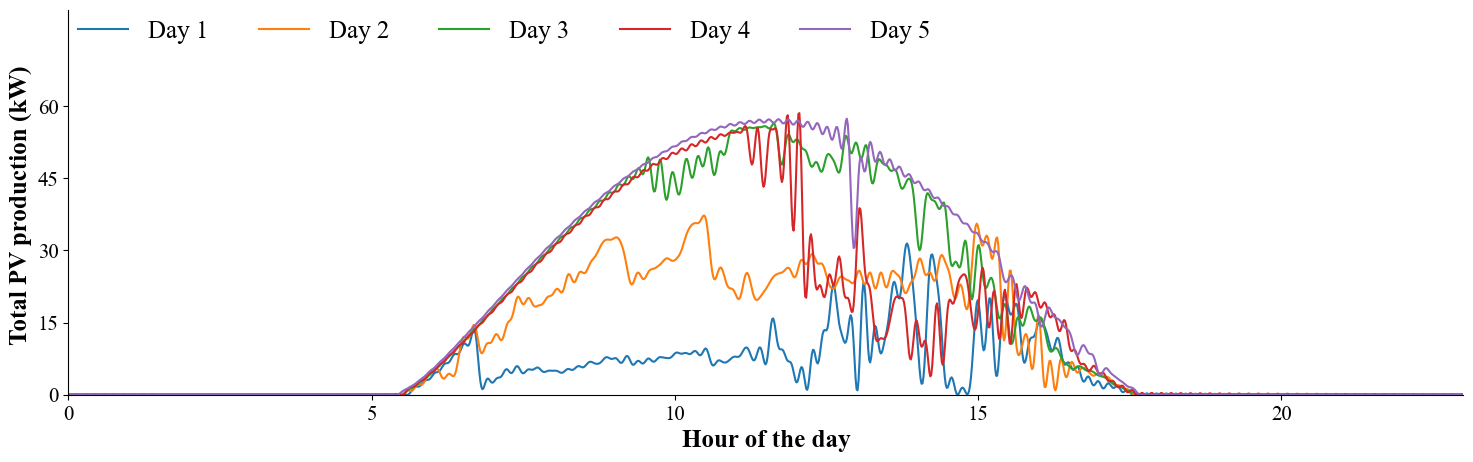

In [115]:
# Plotting first 5 days' PV data
# Plot formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
for day in range(0,5):
    plt.plot(np.linspace(0,23,daily_decision_instants),solar_data[day], label = 'Day ' + str(day+1))

# Plot formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Total PV production (kW) ", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,80)
plt.yticks([0, 15, 30, 45, 60], fontsize = 15);
plt.grid(visible=None)
plt.legend(fontsize=18, loc='upper left', ncol = 5, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

# Input Electricity Price

In [116]:
#Normalized electricity price
electricity_price = np.loadtxt(r'../data/Electricity price/electricity price.csv', delimiter=",")
#Orignal electricity price (non-normalized)
electricity_price_original = np.loadtxt(r'../data/Electricity price/electricity_price_original.csv', delimiter=",")

# Naive charging policy of each EV agent

In [117]:
selected_solar_profile = solar_data[6]

In [118]:
# Create arrays of ones of length len(selected_solar_profile) (decision instants) for each EV ((len(evs_df) EVs)
ev_charging_slots = np.zeros((len(evs_df),len(selected_solar_profile)))
ev_charging_policy = np.zeros((len(evs_df),len(selected_solar_profile)))

# Making the EVs_naive_policy object to calculate the naive policy of all agents
ev_charging_slots, ev_naive_charging_policy = EVs_naive_policy.EVs_naive_policy(evs_df,selected_solar_profile).calculate_naive_policy()

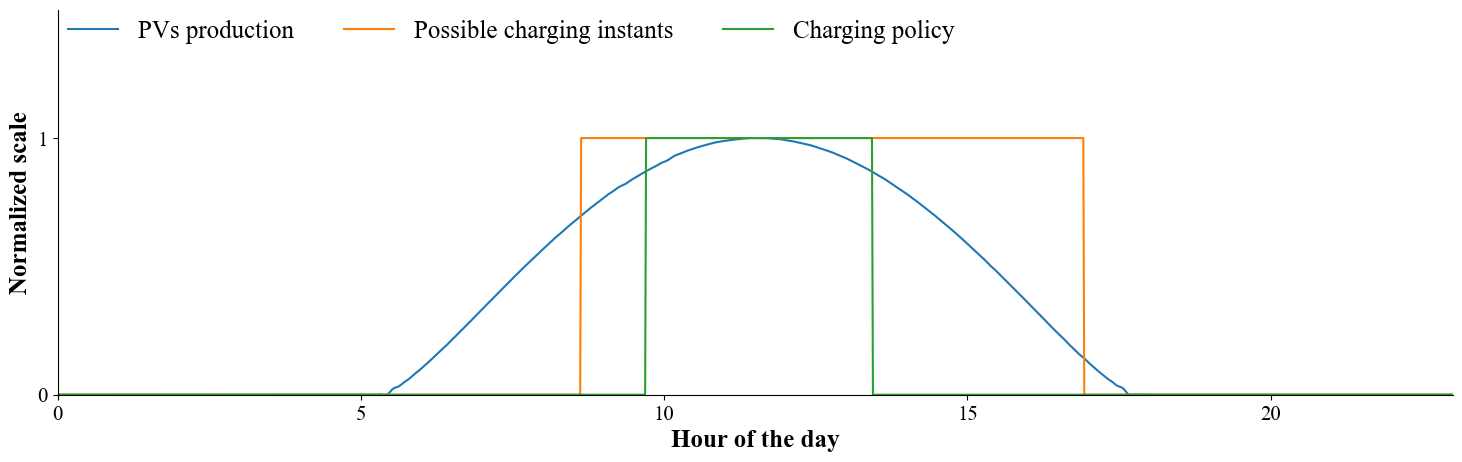

In [119]:
# Plotting selected solar profile for naive policy and possible charging slots and naive policy of the first EV agent
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting results
plt.plot(np.linspace(0,23,daily_decision_instants),selected_solar_profile / np.max(selected_solar_profile))
plt.plot(np.linspace(0,23,daily_decision_instants),ev_charging_slots[0])
plt.plot(np.linspace(0,23,daily_decision_instants),ev_naive_charging_policy[0])

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Normalized scale", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.5)
plt.yticks([0, 1.0], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Possible charging instants', 'Charging policy'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

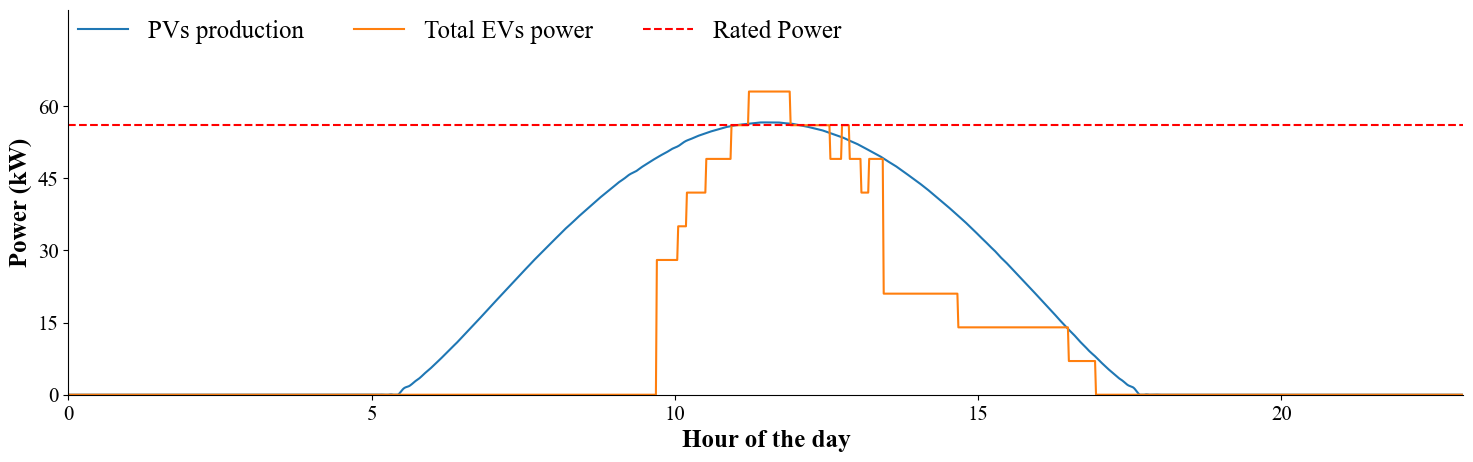

In [120]:
# Plotting cummulative charging powers of all EVs
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,daily_decision_instants),selected_solar_profile)
plt.plot(np.linspace(0,23,daily_decision_instants),np.sum(ev_naive_charging_policy,axis=0)*p_max)
plt.axhline(y=congestion_limit, color='r', linestyle='--')


# Plot formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Power (kW)", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,80)
plt.yticks([0, 15, 30,45,60], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Total EVs power', 'Rated Power'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

# Bandit Optimization
## Performing Bandit optimization for the selected solar PV profile (Deterministic Case)

In [121]:
# One EV from the EVs data is selected as the learning EV and the remaining EVs are non learning EVs
# Non-learning EVs will keep on following the naive policy
# Learning EV will perform optimization

# Index of each non-learning EV
selected_study_dumb_evs = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
# Index of the learning EV
selected_study_learning_ev = np.array([10])

In [122]:
# Initializing an Agent named "Agent 1" that needs
agent_name = "Learning_EV"
arrival_time = evs_df['t_arrive'][selected_study_learning_ev[0]]
departure_time = evs_df['t_depart'][selected_study_learning_ev[0]]
resource_required = evs_df['chrg_req'][selected_study_learning_ev[0]]
instants = daily_decision_instants
alpha = 1

ev_learning_agent = EV_TS_Agent.EV_TS_Agent(agent_name, arrival_time, departure_time , resource_required, daily_decision_instants, alpha, ev_naive_charging_policy[selected_study_learning_ev[0]])

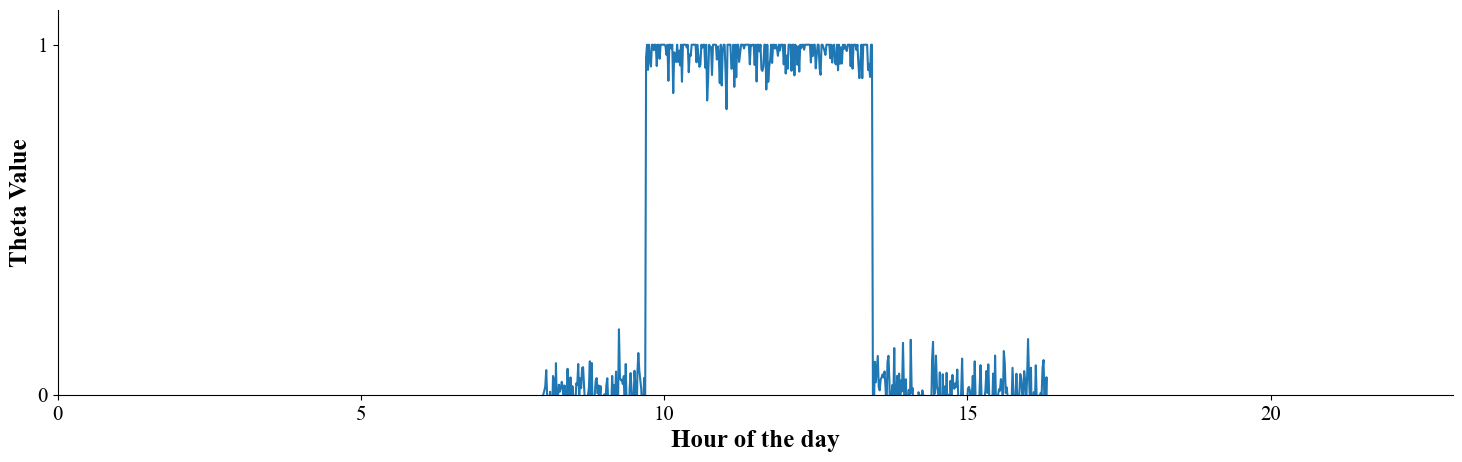

In [123]:
# Plotting the unknown parameter vector theta

# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,daily_decision_instants), ev_learning_agent.get_theta())

# Plot Formatting
plt.grid(visible=None)
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Theta Value", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.1)
plt.yticks([0,1])
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

In [124]:
# Simulation parameters
training_days = 60
reward_scaling_factor = 10

In [125]:
# Declaring variables to store simulation results
dumb_evs_charging_power = np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max
total_instantaneous_consumption_arr = []
daily_charging_cost_bandit = np.zeros(training_days)
reward_hist = []

for time in tqdm(range(0,training_days*daily_decision_instants)):
    minute_of_day = time%1440
    total_instantaneous_consumption = 0
    learning_agent_reward = 0
    #selected_pv_profile_b = solar_data[np.floor(time/daily_decision_instants).astype(int)]
    selected_pv_profile_b = solar_data[6]

    # Select the agent's playing policy at the start of the day
    if (minute_of_day == 0):
        ev_learning_agent.select_actions()

    # Calculating the instantaneous total power consuming the distribution network
    if (minute_of_day in ev_learning_agent.get_selected_actions()):
        total_instantaneous_consumption = dumb_evs_charging_power[minute_of_day] + p_max
    else:
        total_instantaneous_consumption = dumb_evs_charging_power[minute_of_day]
    total_instantaneous_consumption_arr.append(total_instantaneous_consumption)

    # Giving reward to the learning EV agent. The reward is:
    # bad: if there is congestion in the network
    # depends on the instantaneous electricity price and PV generation: otherwise
    if ((minute_of_day in ev_learning_agent.get_selected_actions()) and (total_instantaneous_consumption > congestion_limit)):
        learning_agent_reward = -1 * reward_scaling_factor
        ev_learning_agent.update_estimate(minute_of_day,learning_agent_reward)
        reward_hist.append(learning_agent_reward)
    elif ((minute_of_day in ev_learning_agent.get_selected_actions()) and (total_instantaneous_consumption <= congestion_limit)):
        learning_agent_reward = 1 - (np.maximum(p_max - np.maximum((selected_pv_profile_b[minute_of_day] - dumb_evs_charging_power[minute_of_day]),0),0)/p_max) * (electricity_price_original[minute_of_day]*reward_scaling_factor)
        ev_learning_agent.update_estimate(minute_of_day,learning_agent_reward)
        reward_hist.append(learning_agent_reward)

    # Calculating daily charging cost of the learning EV agent at the end of the day
    if (minute_of_day == (daily_decision_instants-1)):
        daily_charging_cost_bandit[np.floor(time/1440).astype(int)] = np.maximum((total_instantaneous_consumption_arr[np.floor(time/1440).astype(int)*1440:(np.floor(time/1440).astype(int)+1)*1440] - dumb_evs_charging_power) - np.maximum((selected_pv_profile_b - (np.sum(ev_charging_policy[selected_study_dumb_evs],axis=0)*p_max)),0),0)@(electricity_price_original/60)

100%|██████████| 86400/86400 [00:01<00:00, 47251.84it/s]


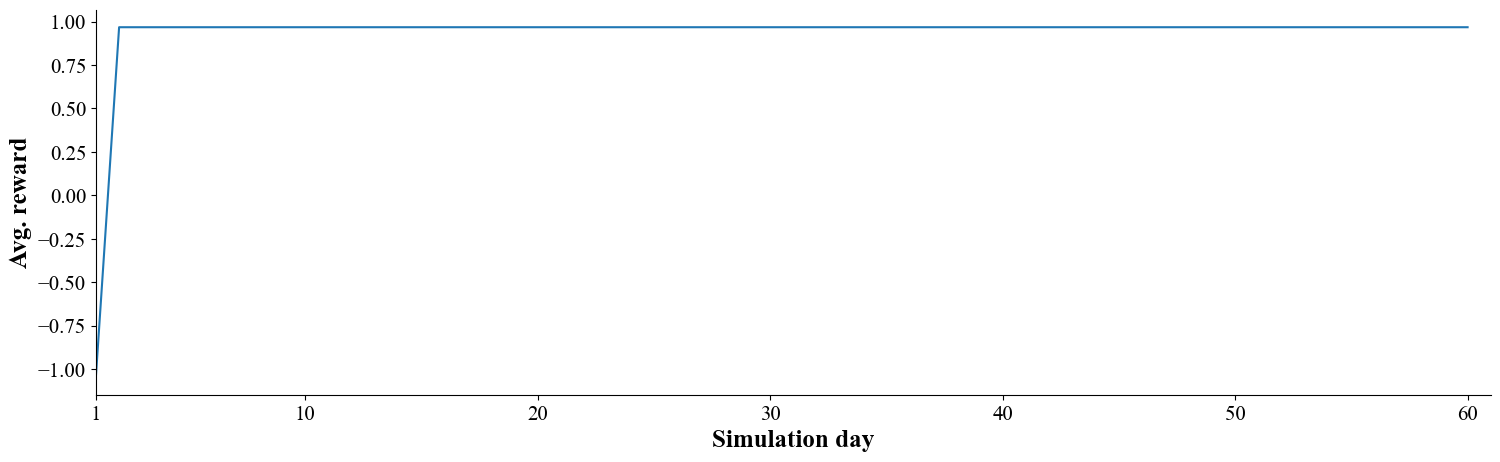

In [126]:
# Plotting the unknown parameter vector theta

# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.average(np.array(reward_hist).reshape(-1, resource_required), axis=1))

# Plot Formatting
plt.grid(visible=None)
plt.xlabel('Simulation day', weight = 'bold', fontsize = 18)
plt.ylabel("Avg. reward", weight = 'bold', fontsize = 18)
plt.xlim(0,60)
plt.xticks([0,9,19,29,39,49,59],[1,10,20,30,40,50,60])
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

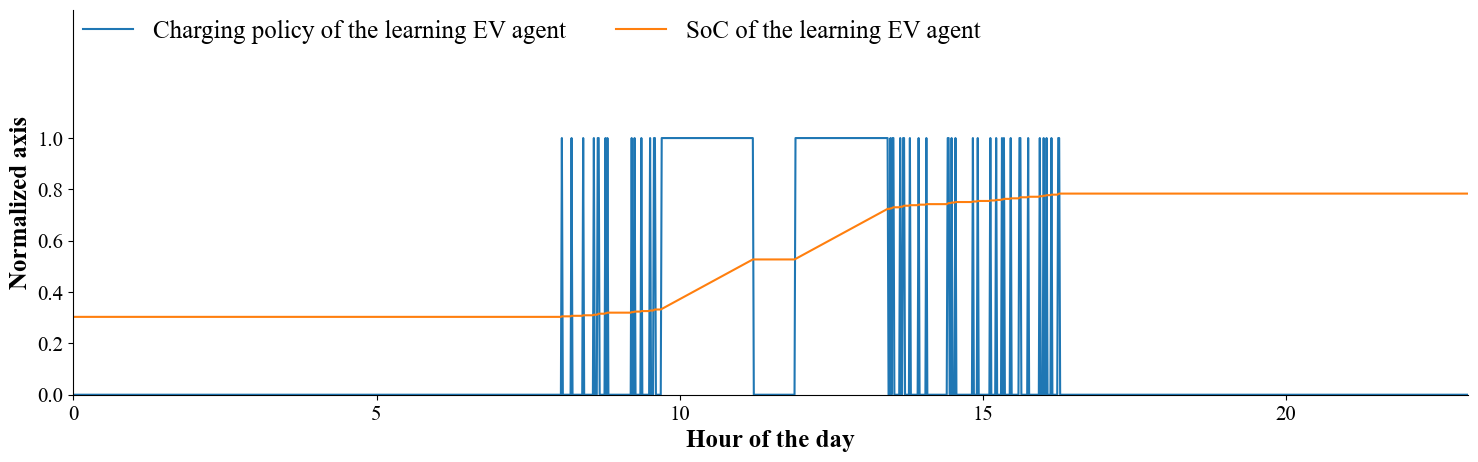

In [127]:
# Plotting optimized charging policy and SoC of the learning EV agent
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,1440),((total_instantaneous_consumption_arr[(training_days - 1) * 1440:(training_days) * 1440] - np.sum(
    ev_naive_charging_policy[selected_study_dumb_evs], axis=0) * p_max) / p_max))
plt.plot(np.linspace(0,23,1440),np.cumsum((total_instantaneous_consumption_arr[(training_days-1)*1440:(training_days)*1440] - np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max) * bat_eff) / (e_bat*60) + evs_df['soc_i'][selected_study_learning_ev[0]])

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Normalized axis", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.5)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 15);
plt.grid(visible=None)
plt.legend(['Charging policy of the learning EV agent', 'SoC of the learning EV agent'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

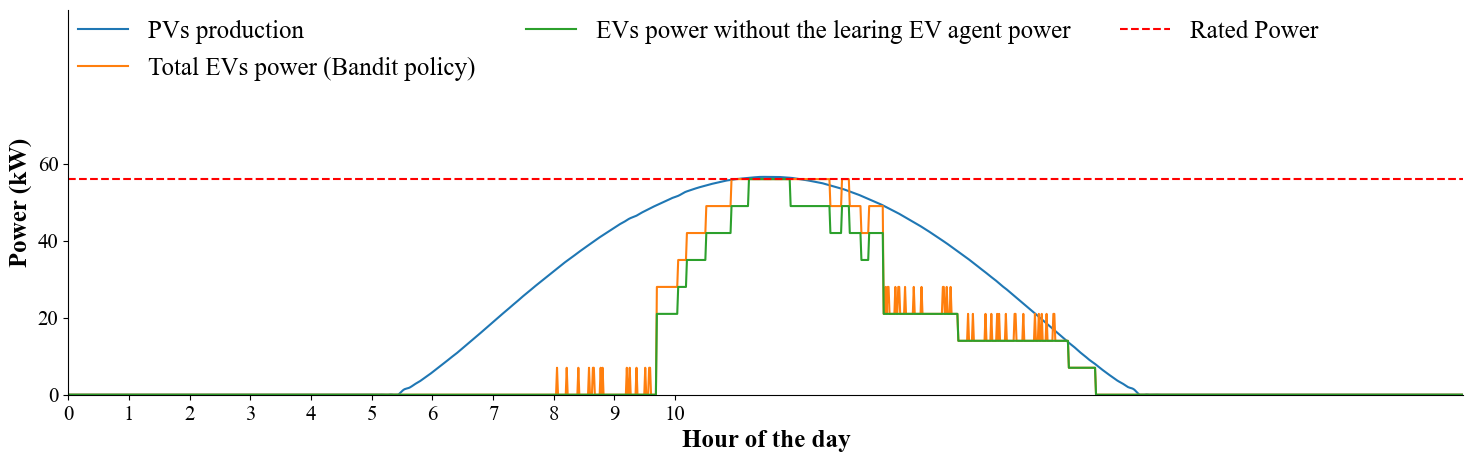

In [128]:
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,1440),selected_pv_profile_b)
plt.plot(np.linspace(0,23,1440),(total_instantaneous_consumption_arr[(training_days-1)*1440:(training_days)*1440]))
plt.plot(np.linspace(0,23,1440),np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max)
plt.axhline(y=56, color='r', linestyle='--')

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Power (kW)", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,100)
plt.yticks([0, 20, 40, 60], fontsize = 15);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Total EVs power (Bandit policy)', 'EVs power without the learing EV agent power', 'Rated Power'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

## Performing Bandit optimization for the each day of thhe solar data array (Stochastic Case)

In [129]:
# Initializing an Agent named "Agent 1" that needs
agent_name = "Learning_EV"
arrival_time = evs_df['t_arrive'][selected_study_learning_ev[0]]
departure_time = evs_df['t_depart'][selected_study_learning_ev[0]]
resource_required = evs_df['chrg_req'][selected_study_learning_ev[0]]
instants = daily_decision_instants
alpha = 1

ev_learning_agent = EV_TS_Agent.EV_TS_Agent(agent_name, arrival_time, departure_time , resource_required, daily_decision_instants, alpha, np.ones(1440))

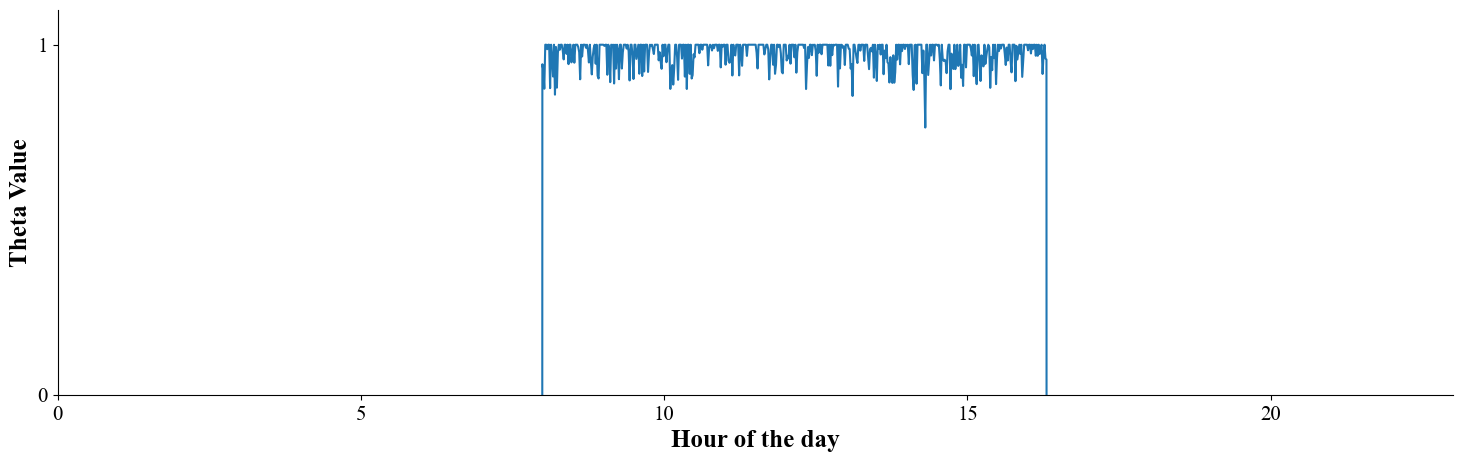

In [130]:
# Plotting the unknown parameter vector theta

# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,daily_decision_instants), ev_learning_agent.get_theta())

# Plot Formatting
plt.grid(visible=None)
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Theta Value", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.1)
plt.yticks([0,1])
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

In [131]:
# Simulation parameters
training_days = 60
reward_scaling_factor = 10

In [132]:
# Declaring variables to store simulation results
dumb_evs_charging_power = np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max
total_instantaneous_consumption_arr = []
daily_charging_cost_bandit = np.zeros(training_days)
reward_hist = []

for time in tqdm(range(0,training_days*daily_decision_instants)):
    minute_of_day = time%1440
    total_instantaneous_consumption = 0
    learning_agent_reward = 0
    selected_pv_profile_b = solar_data[np.floor(time/daily_decision_instants).astype(int)]

    # Select the agent's playing policy at the start of the day
    if (minute_of_day == 0):
        ev_learning_agent.select_actions()

    # Calculating the instantaneous total power consuming the distribution network
    if (minute_of_day in ev_learning_agent.get_selected_actions()):
        total_instantaneous_consumption = dumb_evs_charging_power[minute_of_day] + p_max
    else:
        total_instantaneous_consumption = dumb_evs_charging_power[minute_of_day]
    total_instantaneous_consumption_arr.append(total_instantaneous_consumption)

    # Giving reward to the learning EV agent. The reward is:
    # bad: if there is congestion in the network
    # depends on the instantaneous electricity price and PV generation: otherwise
    if ((minute_of_day in ev_learning_agent.get_selected_actions()) and (total_instantaneous_consumption > congestion_limit)):
        learning_agent_reward = -1 * reward_scaling_factor
        ev_learning_agent.update_estimate(minute_of_day,learning_agent_reward)
        reward_hist.append(learning_agent_reward)
    elif ((minute_of_day in ev_learning_agent.get_selected_actions()) and (total_instantaneous_consumption <= congestion_limit)):
        learning_agent_reward = 1 - (np.maximum(p_max - np.maximum((selected_pv_profile_b[minute_of_day] - dumb_evs_charging_power[minute_of_day]),0),0)/p_max) * (electricity_price_original[minute_of_day]*reward_scaling_factor)
        ev_learning_agent.update_estimate(minute_of_day,learning_agent_reward)
        reward_hist.append(learning_agent_reward)

    # Calculating daily charging cost of the learning EV agent at the end of the day
    if (minute_of_day == (daily_decision_instants-1)):
        daily_charging_cost_bandit[np.floor(time/1440).astype(int)] = np.maximum((total_instantaneous_consumption_arr[np.floor(time/1440).astype(int)*1440:(np.floor(time/1440).astype(int)+1)*1440] - dumb_evs_charging_power) - np.maximum((selected_pv_profile_b - (np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max)),0),0)@(electricity_price_original/60)

100%|██████████| 86400/86400 [00:02<00:00, 41951.94it/s]


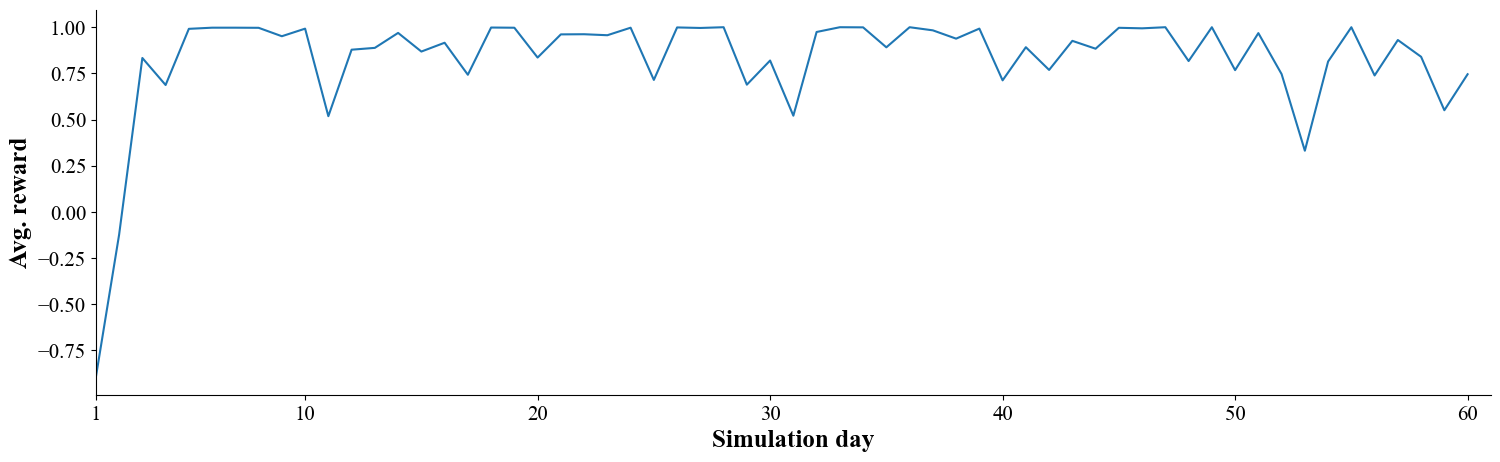

In [139]:
# Plotting the unknown parameter vector theta

# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.average(np.array(reward_hist).reshape(-1, resource_required), axis=1))

# Plot Formatting
plt.grid(visible=None)
plt.xlabel('Simulation day', weight = 'bold', fontsize = 18)
plt.ylabel("Avg. reward", weight = 'bold', fontsize = 18)
plt.xlim(0,60)
plt.xticks([0,9,19,29,39,49,59],[1,10,20,30,40,50,60])
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1);

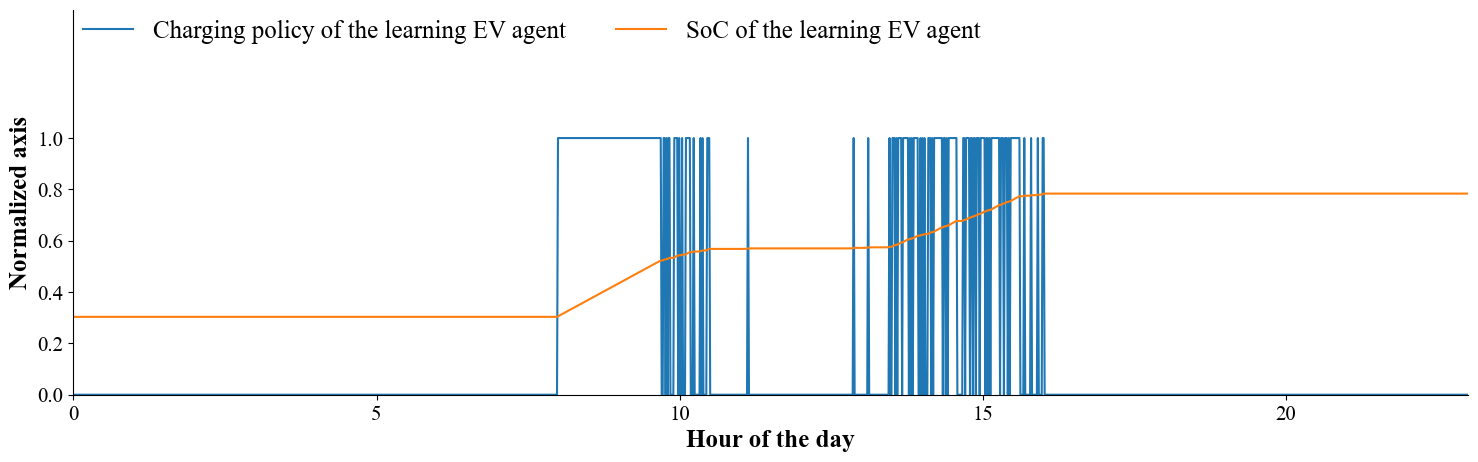

In [133]:
# Plotting optimized charging policy and SoC of the learning EV agent
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,1440),((total_instantaneous_consumption_arr[(training_days - 1) * 1440:(training_days) * 1440] - np.sum(
    ev_naive_charging_policy[selected_study_dumb_evs], axis=0) * p_max) / p_max))
plt.plot(np.linspace(0,23,1440),np.cumsum((total_instantaneous_consumption_arr[(training_days-1)*1440:(training_days)*1440] - np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max) * bat_eff) / (e_bat*60) + evs_df['soc_i'][selected_study_learning_ev[0]])

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Normalized axis", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,1.5)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 15);
plt.grid(visible=None)
plt.legend(['Charging policy of the learning EV agent', 'SoC of the learning EV agent'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

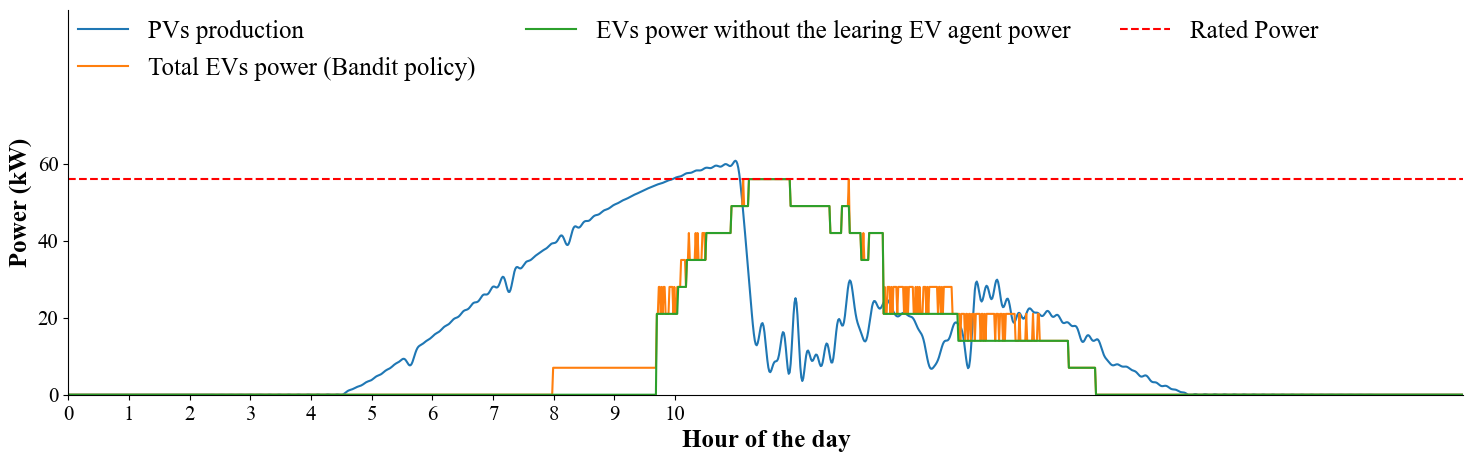

In [134]:
# Plot Formatting
fig, ax = plt.subplots(figsize=(18,5), dpi= 100, facecolor='w', edgecolor='k')
plt.grid(visible=None)
plt.style.use('default')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'size': 15}
plt.rc('font', **font)

# Plotting curves
plt.plot(np.linspace(0,23,1440),selected_pv_profile_b)
plt.plot(np.linspace(0,23,1440),(total_instantaneous_consumption_arr[(training_days-1)*1440:(training_days)*1440]))
plt.plot(np.linspace(0,23,1440),np.sum(ev_naive_charging_policy[selected_study_dumb_evs],axis=0)*p_max)
plt.axhline(y=56, color='r', linestyle='--')

# Plot Formatting
plt.xlabel('Hour of the day', weight = 'bold', fontsize = 18)
plt.ylabel("Power (kW)", weight = 'bold', fontsize = 18)
plt.xlim(0,23)
plt.ylim(0,100)
plt.yticks([0, 20, 40, 60], fontsize = 15);
plt.xticks([0,1,2,3,4,5,6,7,8,9,10], fontsize = 15);
plt.grid(visible=None)
plt.legend(['PVs production', 'Total EVs power (Bandit policy)', 'EVs power without the learing EV agent power', 'Rated Power'], fontsize=18, loc='upper left', ncol = 3, borderaxespad=0, frameon=False)
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(1)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(1)

### Comparison of daily charging costs of different charging strategies

In [135]:
# Calculating the daily charging cost of the learning EV if it follows naive policy
naive_policy_costs = []
for i in range(0, 60):
    naive_policy_costs.append(np.maximum(ev_naive_charging_policy[selected_study_learning_ev[0]] * p_max - np.maximum(
        (1*solar_data[i] - (np.sum(ev_naive_charging_policy[selected_study_dumb_evs], axis=0) * p_max)), 0), 0) @ (
                                      electricity_price_original / 60))

In [136]:
# Array to store daily charging cost of the learning EV agent
milp_daily_costs = np.zeros(len(solar_data))

# Performing MILP optimziation for each day
for day in tqdm(range(0,len(solar_data))):
    # Calling the optimize() function of the EV_milp_policy class
    milp_cost,learning_ev_milp_policy = EV_milp_policy.EV_milp_policy(daily_decision_instants,selected_study_dumb_evs,selected_study_learning_ev,ev_naive_charging_policy,p_max,congestion_limit,evs_df,solar_data[day],electricity_price_original ).optimize()
    # Storing daily charging cost
    milp_daily_costs[day] = milp_cost

100%|██████████| 60/60 [00:07<00:00,  8.15it/s]


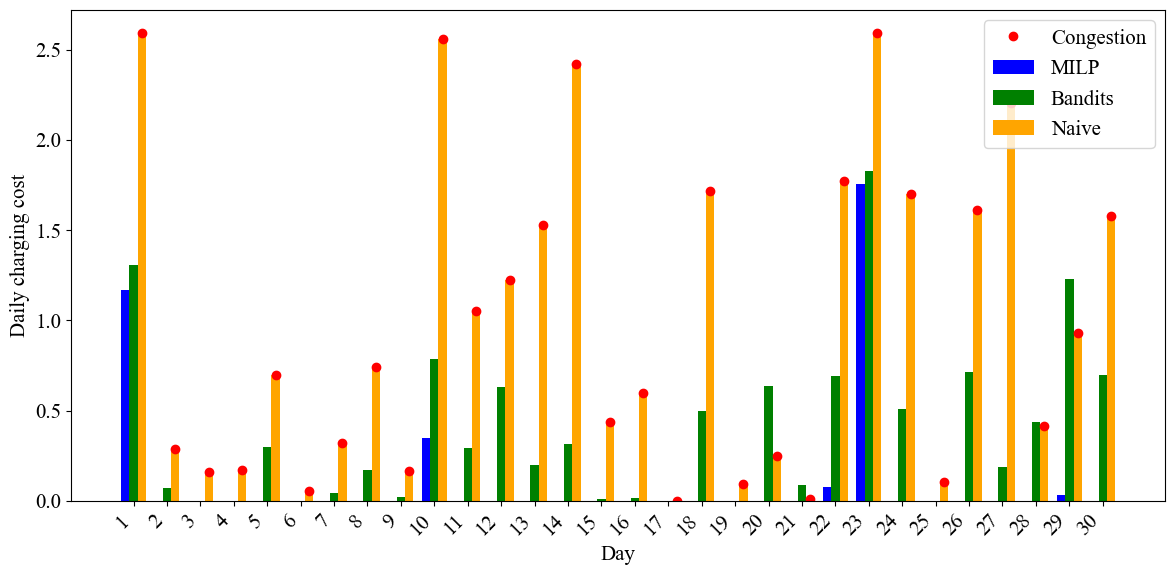

In [137]:
# MILP Notebook should be run first to run this block
labels = [f'{i+1}' for i in range(30)]

values1 = milp_daily_costs[30:]  # MILP costs
values2 = daily_charging_cost_bandit[30:]  # Bandits costs
values3 = naive_policy_costs[30:]  # Naive policy costs

# Create a bar chart
width = 0.25  # Width of the bars
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(x - width, values1, width, label='MILP', color='blue')
bar2 = ax.bar(x, values2, width, label='Bandits', color='green')
bar3 = ax.bar(x + width, values3, width, label='Naive', color='orange')


# Add dots on top of bar3 data
for i, value in enumerate(values3):
    ax.plot(x[i] + width / 1, value, 'ro', markersize=6, label='Congestion' if i == 0 else "_nolegend_")  # 'ro' for red dots

# Add labels, title, and legend
ax.set_xlabel('Day')
ax.set_ylabel('Daily charging cost')
#ax.set_title('Comparison of charging po')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()